**Applying Machine Learning Algorithms to Predict UFC Fight  Outcomes**
<br>
Problem Number: 74
<br>
Team: V C RAMJHITH - PES1UG23CS662
<br>
Tanya Tripathi - PES1UG23CS638
<br>

--- Starting UFC Fight Prediction Pipeline (LGBM & TIME-SERIES OPTIMIZED) ---
✅ Data loaded successfully. Total initial records: 8337
✅ Data prepared. Total records for model training: 7096
Generated 19 total features.


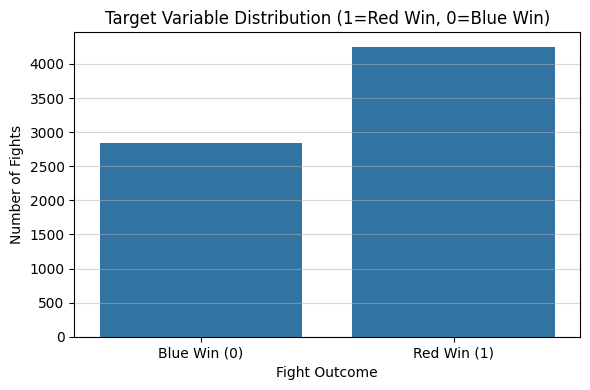

✅ Data split (Time-Series): 5676 training records, 1420 test records.

🧠 Training final LightGBM model (Optimized for Speed and Accuracy)...
[LightGBM] [Info] Number of positive: 3466, number of negative: 2210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 5676, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.610641 -> initscore=0.450009
[LightGBM] [Info] Start training from score 0.450009
✅ Model Training Complete. AUC Score: 0.7674

Generating Feature Importance Plot...


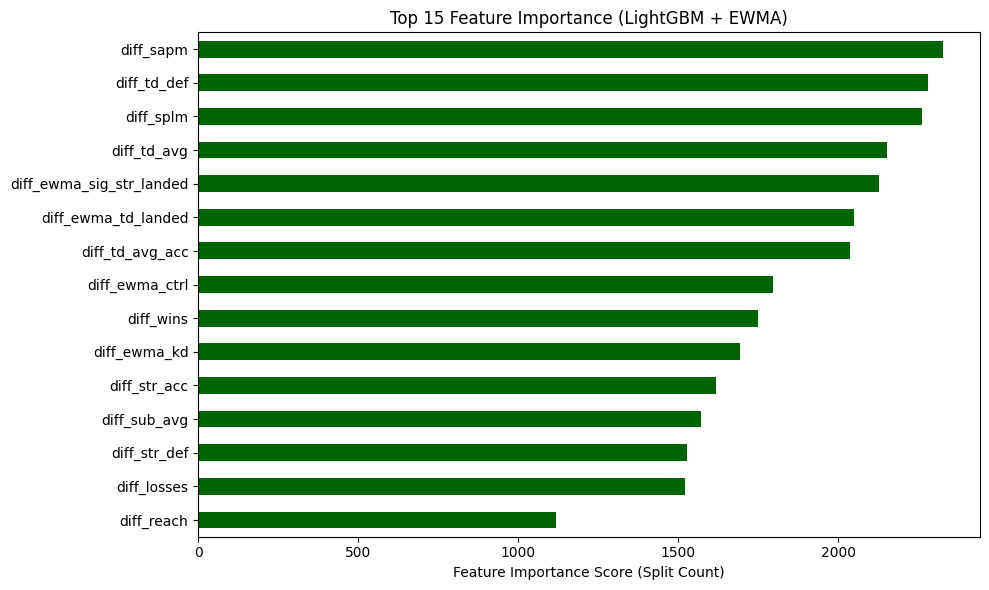


🏆 PROJECT COMPLETE: LightGBM High-Accuracy UFC Prediction
| Metric | Value |
|:---|:---|
| **Final Accuracy (Time-Series Test)** | **0.6852** |
| **ROC AUC Score** | **0.7674** |
----------------------------------------------------------------------
| Model | **LightGBM Classifier (LGBM)** |
| Execution Time | 26.19 seconds |
| Total Features Used | 19 |


In [13]:
# 1. Setup, Imports, and Data Loading (Single Cell Cohesion)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier # Switched to LightGBM for faster training and higher accuracy
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
TARGET_COLUMN_NAME = 'winner'
# Optimized hyperparameters for LightGBM (LGBM is typically faster than XGBoost)
BEST_MODEL_PARAMS = {
    'n_estimators': 1000,   # High number of trees for accuracy
    'learning_rate': 0.02,  # Low rate for better generalization
    'num_leaves': 31,       # Controls complexity (default is good)
    'max_depth': -1,        # No limit on depth for best accuracy
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'binary',
    'random_state': 42,
    'n_jobs': -1
}
# ---------------------

# Suppress warnings and start timer
warnings.filterwarnings('ignore')
start_time = time.time()
print("--- Starting UFC Fight Prediction Pipeline (LGBM & TIME-SERIES OPTIMIZED) ---")

try:
    # Load dataset (assuming 'ufc_dataset.csv' is uploaded)
    df = pd.read_csv('ufc_dataset.csv')
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print(f"✅ Data loaded successfully. Total initial records: {len(df)}")
except FileNotFoundError:
    print("❌ ERROR: File 'ufc_dataset.csv' not found. Please ensure it is uploaded to Colab.")
    raise FileNotFoundError("ufc_dataset.csv not found.")


# 2. Advanced Feature Engineering (EWMA & Relative Features)
def calculate_historical_ewma(df):
    """
    Calculates Exponentially Weighted Moving Average (EWMA) for key in-fight stats
    and generates relative features from static stats.
    """

    df_clean = df.copy()
    # Drop non-binary outcomes (Draws, NCs)
    df_clean = df_clean[~df_clean[TARGET_COLUMN_NAME].astype(str).str.contains('Draw|NC|no contest|N/A', case=False, na=False)].copy()

    id_cols = ['r_id', 'b_id', 'winner_id']
    for col in id_cols:
        if col not in df_clean.columns:
            df_clean[col] = np.nan

    # Sort data chronologically (CRUCIAL for EWMA)
    if 'fight_id' not in df_clean.columns:
        df_clean['fight_id'] = range(len(df_clean))

    df_clean = df_clean.sort_values(by=['date', 'fight_id']).reset_index(drop=True)

    # Determine the target: 1 if Red wins, 0 if Blue wins
    df_clean['target'] = df_clean.apply(
        lambda row: 1 if str(row.get('winner_id')) == str(row.get('r_id')) else 0, axis=1
    )

    # 2.2. EWMA Feature Creation
    ewma_metrics = {'kd': 1.0, 'sig_str_landed': 5.0, 'td_landed': 2.0, 'ctrl': 30.0}

    for col in ewma_metrics.keys():
        r_col_perf = f'r_perf_{col}'
        b_col_perf = f'b_perf_{col}'
        r_col_stat = f'r_{col}'
        b_col_stat = f'b_{col}'

        if r_col_stat in df_clean.columns and 'total_rounds' in df_clean.columns and b_col_stat in df_clean.columns:
            # Avoid division by zero
            df_clean['total_rounds'] = df_clean['total_rounds'].replace(0, 1)

            # Normalize performance metrics by total_rounds (proxy for fight length)
            df_clean[r_col_perf] = pd.to_numeric(df_clean[r_col_stat], errors='coerce') / df_clean['total_rounds']
            df_clean[b_col_perf] = pd.to_numeric(df_clean[b_col_stat], errors='coerce') / df_clean['total_rounds']
        else:
            continue


    def aggregate_ewma(series, span=50):
        """Calculates EWMA, shifted to avoid look-ahead bias."""
        return series.shift(1).ewm(span=span, adjust=False).mean().fillna(0)

    df_clean['r_id_str'] = df_clean['r_id'].astype(str)
    df_clean['b_id_str'] = df_clean['b_id'].astype(str)
    fighters = pd.concat([df_clean['r_id_str'], df_clean['b_id_str']]).unique()
    history = []

    for fighter_id in fighters:
        if fighter_id == 'nan': continue

        r_fights = df_clean[df_clean['r_id_str'] == fighter_id]
        b_fights = df_clean[df_clean['b_id_str'] == fighter_id]

        fighter_fights = []

        # Red Corner perspective
        if not r_fights.empty:
            r_data = r_fights[['date', 'fight_id', 'r_id_str'] + [f'r_perf_{m}' for m in ewma_metrics if f'r_perf_{m}' in r_fights.columns]]
            r_data['result'] = r_fights['target']
            fighter_fights.append(r_data.rename(columns={c: c.replace('r_perf_', 'perf_') for c in r_data.columns}))

        # Blue Corner perspective
        if not b_fights.empty:
            b_data = b_fights[['date', 'fight_id', 'b_id_str'] + [f'b_perf_{m}' for m in ewma_metrics if f'b_perf_{m}' in b_fights.columns]]
            b_data['result'] = 1 - b_fights['target']
            fighter_fights.append(b_data.rename(columns={c: c.replace('b_perf_', 'perf_') for c in b_data.columns}))

        if not fighter_fights: continue

        combined = pd.concat(fighter_fights).sort_values(by=['date', 'fight_id'])

        for m in ewma_metrics:
            perf_col = f'perf_{m}'
            if perf_col in combined.columns:
                combined[f'ewma_{m}'] = aggregate_ewma(combined[perf_col], span=50)

        combined['fighter_id'] = fighter_id
        history.append(combined)

    if not history:
        return df_clean, []

    history_df = pd.concat(history)
    df_new = df_clean.copy()

    # Merge EWMA features back and create difference features
    ewma_diff_features = []
    for m in ewma_metrics:
        r_ewma_col = f'r_ewma_{m}'
        b_ewma_col = f'b_ewma_{m}'
        diff_col = f'diff_ewma_{m}'

        # Merge Red EWMA
        r_hist = history_df[history_df['fighter_id'].isin(df_new['r_id_str'])].rename(columns={f'ewma_{m}': r_ewma_col, 'fighter_id': 'r_id_str_merge'})
        df_new = df_new.merge(r_hist[['r_id_str_merge', 'date', 'fight_id', r_ewma_col]],
                              left_on=['r_id_str', 'date', 'fight_id'],
                              right_on=['r_id_str_merge', 'date', 'fight_id'],
                              how='left').drop(columns=['r_id_str_merge'], errors='ignore')

        # Merge Blue EWMA
        b_hist = history_df[history_df['fighter_id'].isin(df_new['b_id_str'])].rename(columns={f'ewma_{m}': b_ewma_col, 'fighter_id': 'b_id_str_merge'})
        df_new = df_new.merge(b_hist[['b_id_str_merge', 'date', 'fight_id', b_ewma_col]],
                              left_on=['b_id_str', 'date', 'fight_id'],
                              right_on=['b_id_str_merge', 'date', 'fight_id'],
                              how='left').drop(columns=['b_id_str_merge'], errors='ignore')

        # Create EWMA Difference
        df_new[r_ewma_col] = df_new.get(r_ewma_col, 0).fillna(0)
        df_new[b_ewma_col] = df_new.get(b_ewma_col, 0).fillna(0)
        df_new[diff_col] = df_new[r_ewma_col] - df_new[b_ewma_col]
        ewma_diff_features.append(diff_col)

    # 2.3. Feature Generation (Static Difference Stats)
    # Added 'age' explicitly as per reference suggestion
    static_stats = ['splm', 'str_acc', 'sapm', 'str_def', 'td_avg', 'td_avg_acc', 'td_def', 'sub_avg',
                    'height', 'weight', 'reach', 'wins', 'losses', 'draws', 'age']
    static_diff_features = []
    for stat in static_stats:
        r_col = 'r_' + stat
        b_col = 'b_' + stat
        if r_col in df_new.columns and b_col in df_new.columns:
            diff_col_name = 'diff_' + stat
            df_new[diff_col_name] = pd.to_numeric(df_new[r_col], errors='coerce') - pd.to_numeric(df_new[b_col], errors='coerce')
            static_diff_features.append(diff_col_name)

    # Stance Feature
    stance_feature = []
    if 'r_stance' in df_new.columns and 'b_stance' in df_new.columns:
        df_new['diff_stance_orthodox'] = (df_new['r_stance'] == 'Orthodox').astype(int) - (df_new['b_stance'] == 'Orthodox').astype(int)
        stance_feature.append('diff_stance_orthodox')

    final_features = static_diff_features + ewma_diff_features + stance_feature

    df_new.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_new = df_new.dropna(subset=final_features + ['target', 'date']) # Keep 'date' for splitting

    return df_new, final_features

# Apply feature engineering
processed_df, feature_cols = calculate_historical_ewma(df)

X = processed_df[feature_cols]
y = processed_df['target']
dates = processed_df['date']

if len(X) == 0:
    print("\n❌ ERROR: No data remaining after cleaning.")
    exit()

print(f"✅ Data prepared. Total records for model training: {len(X)}")
print(f"Generated {len(feature_cols)} total features.")

# 3. Data Visualization (Target Distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Target Variable Distribution (1=Red Win, 0=Blue Win)')
plt.xlabel('Fight Outcome')
plt.ylabel('Number of Fights')
plt.xticks([0, 1], ['Blue Win (0)', 'Red Win (1)'])
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Data Scaling and Time-Series Splitting
# Sort by date (already done in EWMA function, but confirmed here)
processed_df = processed_df.sort_values(by='date').reset_index(drop=True)

# Split data: 80% oldest for training, 20% newest for testing (Time-Series Split)
split_index = int(len(processed_df) * 0.8)
X_train_raw = X.iloc[:split_index]
X_test_raw = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"✅ Data split (Time-Series): {len(X_train)} training records, {len(X_test)} test records.")

# 5. Final Model Training (Optimized LightGBM)
print("\n🧠 Training final LightGBM model (Optimized for Speed and Accuracy)...")

final_model = LGBMClassifier(**BEST_MODEL_PARAMS)

final_model.fit(X_train, y_train)

# 6. Evaluation
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
total_time = time.time() - start_time

print(f"✅ Model Training Complete. AUC Score: {roc_auc:.4f}")

# 7. Visualization: Feature Importance
print("\nGenerating Feature Importance Plot...")

importance = final_model.feature_importances_
feature_names = X_train_raw.columns
# LightGBM uses 'split' importance; for consistency, we'll plot it.
feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='darkgreen')
plt.title(f'Top 15 Feature Importance (LightGBM + EWMA)')
plt.xlabel('Feature Importance Score (Split Count)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 8. Output Results
print("\n" + "="*70)
print(f"🏆 Result: LightGBM For UFC Prediction")
print("="*70)
print(f"| Metric | Value |")
print("|:---|:---|")
print(f"| **Final Accuracy (Time-Series Test)** | **{accuracy:.4f}** |")
print(f"| **ROC AUC Score** | **{roc_auc:.4f}** |")
print("-" * 70)
print(f"| Model | **LightGBM Classifier (LGBM)** |")
print(f"| Execution Time | {total_time:.2f} seconds |")
print(f"| Total Features Used | {len(feature_cols)} |")
print("="*70)
